# Two-Level System with Bloch-Redfield Baths

We revisit the driven two-level system that produced the Rabi population plots in the thesis draft.
This notebook replaces the phenomenological Lindblad decay with Bloch-Redfield dynamics derived
from explicit spectral densities (Drude-Lorentz and Ohmic). We scan temperatures and coupling
strengths to show how microscopic baths damp the Rabi oscillations.

In [1]:
from __future__ import annotations
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    basis,
    sigmaz,
    sigmax,
    brmesolve,
    DrudeLorentzEnvironment,
    OhmicEnvironment,
)

from diagnostics import trajectory_min_eigs
from plotting import style, populations_from_states

style()

# Add src directory to Python path
notebook_dir = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
FIG_DIR = notebook_dir / "bloch_redfield"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
from dataclasses import dataclass
from typing import Any, Callable, Dict


@dataclass
class Scenario:
    key: str
    title: str
    bath_cls: Callable[..., Any]
    bath_kwargs: Dict[str, Any]
    note: str


def simulate_two_level_br(
    scenario: Scenario,
    *,
    tmax: float = 25.0,
    n_steps: int = 600,
    w0: float = 1.0,
    omega_drive: float = 1.0,
    delta: float = 0.0,
):
    """Propagate the driven qubit with Bloch-Redfield dynamics for one bath scenario."""
    tlist = np.linspace(0.0, tmax, n_steps)
    H = 0.5 * w0 * sigmaz() + 0.5 * omega_drive * sigmax()
    if delta:
        H += 0.5 * delta * sigmaz()
    psi0 = basis(2, 1)
    bath = scenario.bath_cls(**scenario.bath_kwargs)
    result = brmesolve(
        H=H,
        psi0=psi0,
        tlist=tlist,
        a_ops=[[sigmax(), bath]],
        e_ops=[],
        sec_cutoff=-1
    )
    pops = populations_from_states(result.states)
    min_eigs = trajectory_min_eigs(result.states)
    return {
        "scenario": scenario,
        "tlist": tlist,
        "pops": pops,
        "min_eigs": min_eigs,
        "states": result.states,
        "bath": bath,
    }

In [3]:
scenarios = [
    Scenario(
        key="drude_low_coupling",
        title="Drude-Lorentz: T=0.05, λ=0.02",
        bath_cls=DrudeLorentzEnvironment,
        bath_kwargs={"T": 0.05, "lam": 0.02, "gamma": 4.0, "Nk": 4},
        note="Weak coupling and cold bath ⇒ almost coherent Rabi oscillations.",
    ),
    Scenario(
        key="drude_hot_strong",
        title="Drude-Lorentz: T=0.5, λ=0.08",
        bath_cls=DrudeLorentzEnvironment,
        bath_kwargs={"T": 0.5, "lam": 0.08, "gamma": 2.0, "Nk": 4},
        note="Hotter bath plus stronger coupling damps oscillations towards thermal equilibrium.",
    ),
    Scenario(
        key="ohmic_low_temp",
        title="Ohmic: T=0.1, α=0.03",
        bath_cls=OhmicEnvironment,
        bath_kwargs={"T": 0.1, "wc": 8.0, "alpha": 0.03, "s": 1.0},
        note="Ohmic spectrum with modest coupling (quasi-Markovian).",
    ),
    Scenario(
        key="ohmic_hot_strong",
        title="Ohmic: T=0.6, α=0.09",
        bath_cls=OhmicEnvironment,
        bath_kwargs={"T": 0.6, "wc": 6.0, "alpha": 0.09, "s": 1.0},
        note="Hot Ohmic bath and strong coupling accelerate relaxation to the ground state.",
    ),
]

results = [simulate_two_level_br(scn, tmax=25.0, n_steps=600) for scn in scenarios]
print(f"Simulated {len(results)} scenarios.")

Simulated 4 scenarios.


/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/qutip/core/environment.py:1647: UserWarning: The mpmath module is required for some operations on Ohmic environments, but it is not installed.
  warnings.warn(


Saved population figure to /home/leopold/Projects/redfield_education/notebooks/bloch_redfield/two_level_br_populations.svg


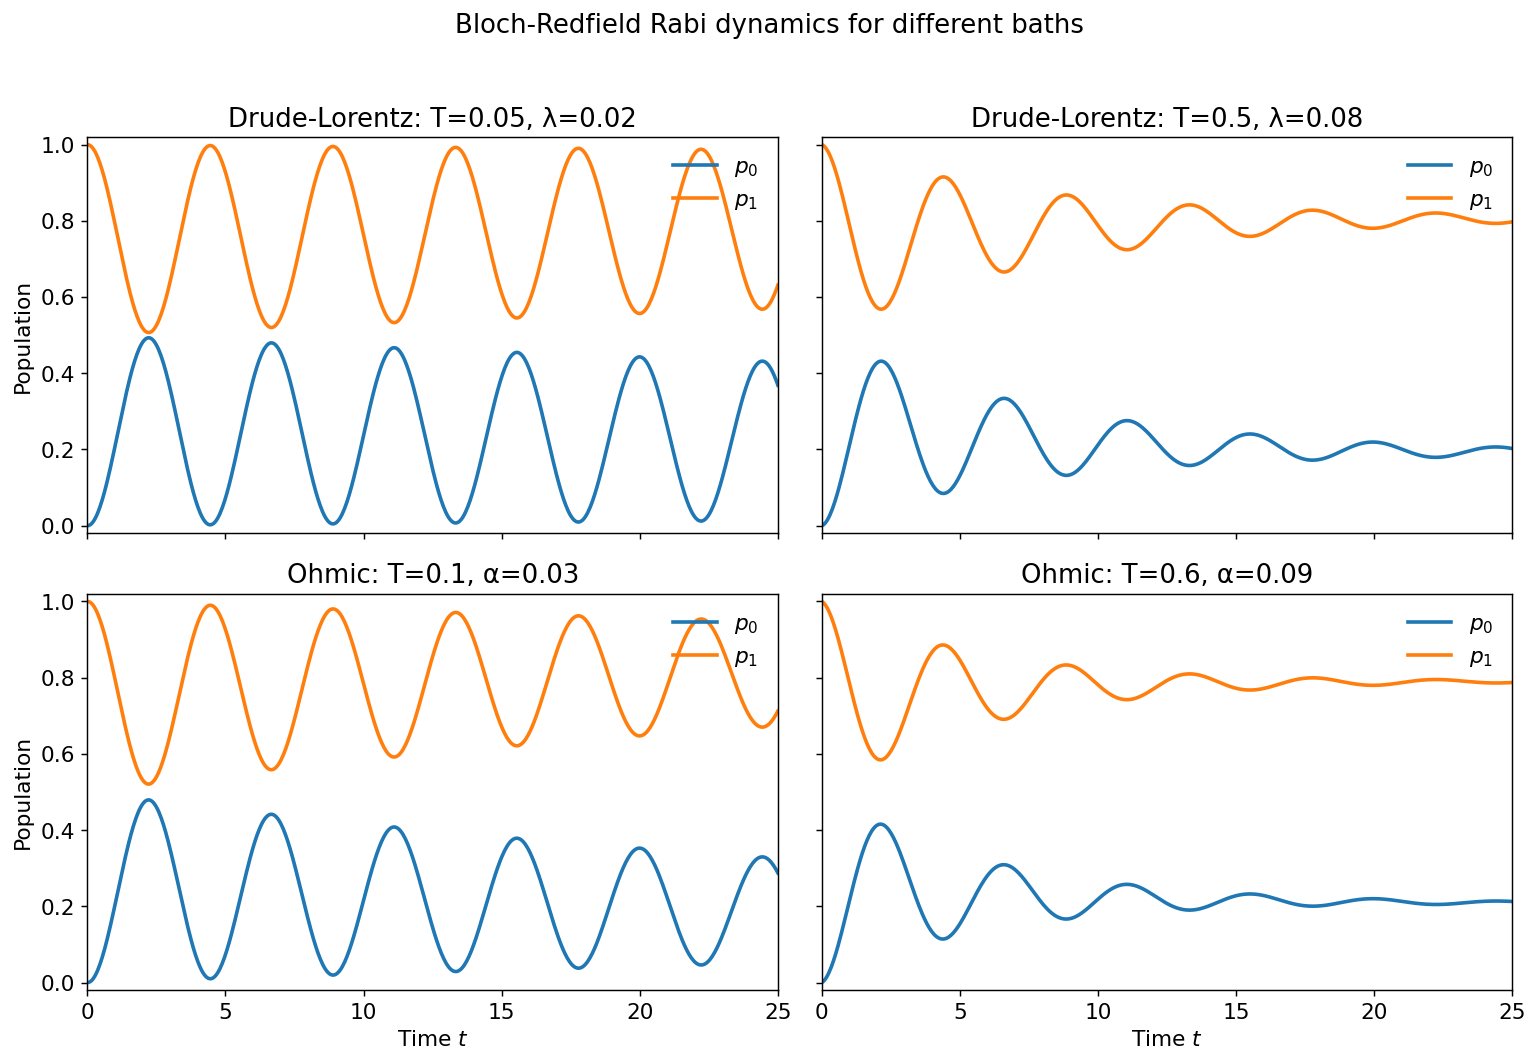

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, res in zip(axes, results):
    pops = res["pops"]
    tlist = res["tlist"]
    ax.plot(tlist, pops[0], label=r"$p_0$", color="C0")
    ax.plot(tlist, pops[1], label=r"$p_1$", color="C1")
    ax.set_title(res["scenario"].title)
    ax.set_xlim(tlist[0], tlist[-1])
    ax.set_ylim(-0.02, 1.02)
    ax.legend(frameon=False, loc="upper right")

for ax in axes[2:]:
    ax.set_xlabel(r"Time $t$")
for ax in axes[::2]:
    ax.set_ylabel("Population")

fig.suptitle("Bloch-Redfield Rabi dynamics for different baths", y=1.02)
fig.tight_layout()
pop_fig_path = FIG_DIR / "two_level_br_populations.svg"
fig.savefig(pop_fig_path, transparent=True)
print(f"Saved population figure to {pop_fig_path}")

Saved positivity figure to /home/leopold/Projects/redfield_education/notebooks/bloch_redfield/two_level_br_min_eigs.svg


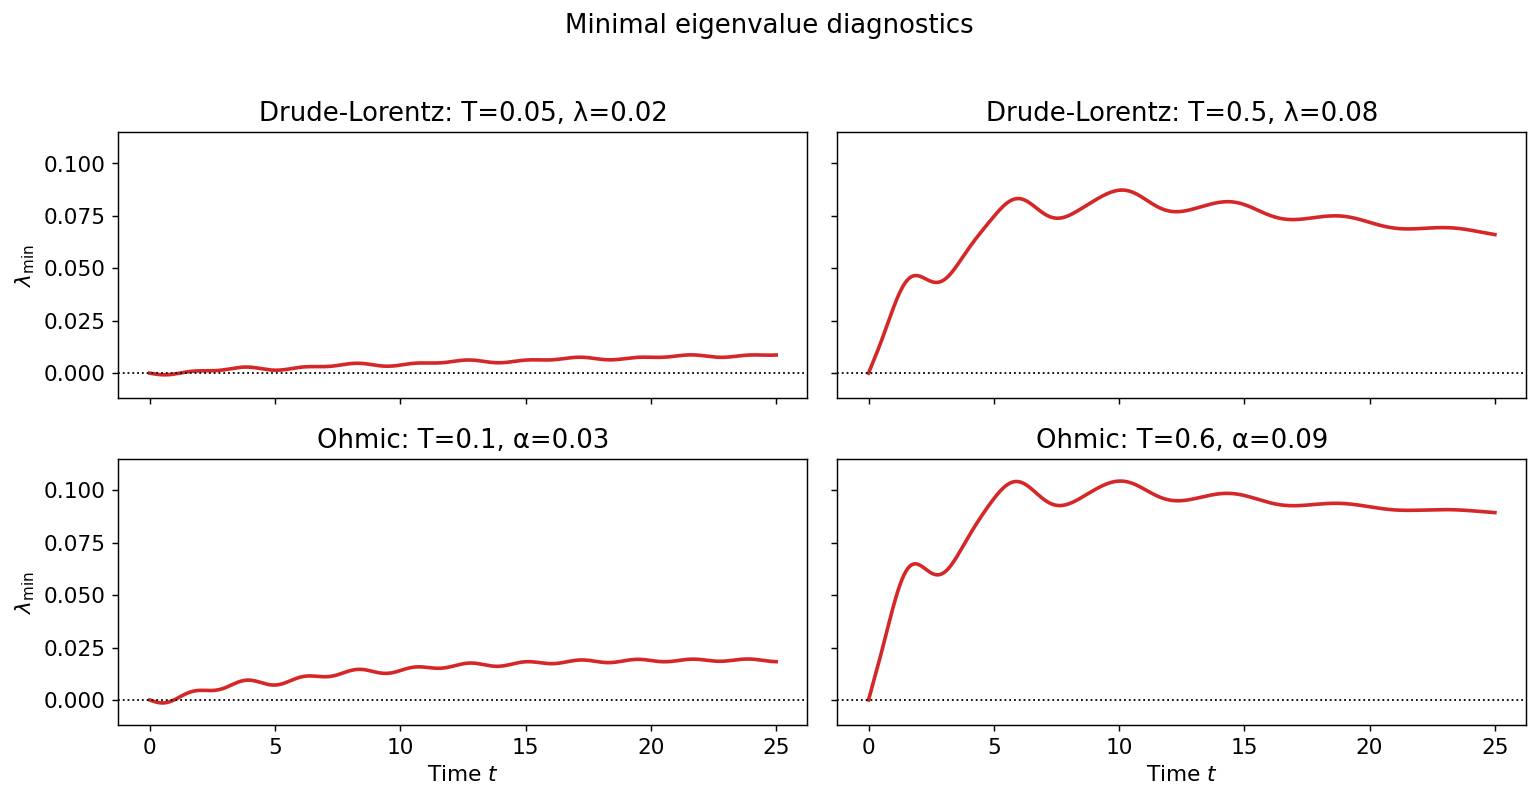

In [5]:
min_all = min(res["min_eigs"].min() for res in results)
max_all = max(res["min_eigs"].max() for res in results)
pad = max(1e-5, 0.1 * (max_all - min_all) if max_all > min_all else 1e-5)
y_limits = (min_all - pad, max_all + pad)

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()
for ax, res in zip(axes, results):
    ax.plot(res["tlist"], res["min_eigs"], color="C3")
    ax.axhline(0.0, color="k", lw=1, ls=":")
    ax.set_title(res["scenario"].title)
    ax.set_ylim(*y_limits)

for ax in axes[2:]:
    ax.set_xlabel(r"Time $t$")
for ax in axes[::2]:
    ax.set_ylabel(r"$\lambda_{\min}$")

fig.suptitle("Minimal eigenvalue diagnostics", y=1.02)
fig.tight_layout()
eig_fig_path = FIG_DIR / "two_level_br_min_eigs.svg"
fig.savefig(eig_fig_path, transparent=True)
print(f"Saved positivity figure to {eig_fig_path}")

In [6]:
for res in results:
    scn = res["scenario"]
    coupling = scn.bath_kwargs.get("lam", scn.bath_kwargs.get("alpha"))
    min_lambda = res["min_eigs"].min()
    max_lambda = res["min_eigs"].max()
    print(
        f"{scn.key:>20}: bath={scn.title}, coupling={coupling}, minλ={min_lambda:.3e}, maxλ={max_lambda:.3e}"
    )
    print(f"    note: {scn.note}")

  drude_low_coupling: bath=Drude-Lorentz: T=0.05, λ=0.02, coupling=0.02, minλ=-7.951e-04, maxλ=8.718e-03
    note: Weak coupling and cold bath ⇒ almost coherent Rabi oscillations.
    drude_hot_strong: bath=Drude-Lorentz: T=0.5, λ=0.08, coupling=0.08, minλ=0.000e+00, maxλ=8.727e-02
    note: Hotter bath plus stronger coupling damps oscillations towards thermal equilibrium.
      ohmic_low_temp: bath=Ohmic: T=0.1, α=0.03, coupling=0.03, minλ=-1.414e-03, maxλ=1.953e-02
    note: Ohmic spectrum with modest coupling (quasi-Markovian).
    ohmic_hot_strong: bath=Ohmic: T=0.6, α=0.09, coupling=0.09, minλ=0.000e+00, maxλ=1.043e-01
    note: Hot Ohmic bath and strong coupling accelerate relaxation to the ground state.
